# **Car Price Prediction**
This notebook analyse car prices of various brand and models with its features and also help users predict its price using historical data collected from twitter users. In otherwords, before the dataset was used for prediction thorough data cleaning and exploration was carried out inorder to achieve a statistical significant result.
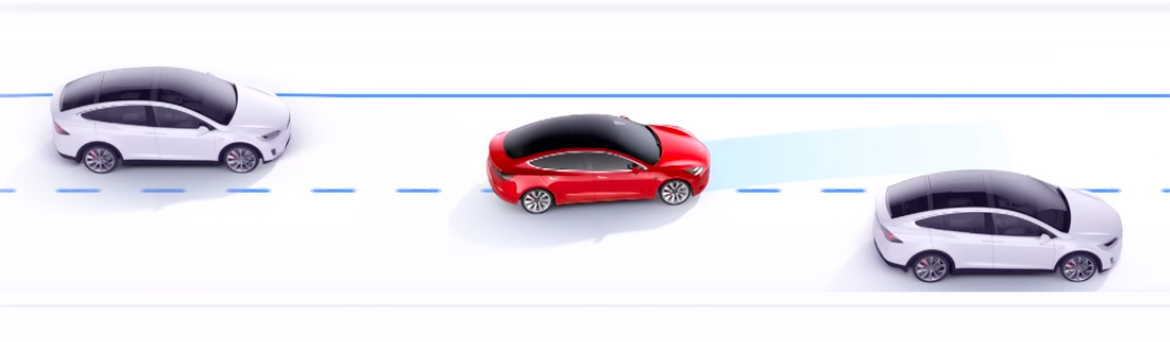

## Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Dataset

In [2]:
car_data = pd.read_csv('dataset/car_price.csv')
car_data[:3]

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350


## Understanding data variables
This will help to understand the variable and their relevance to the prediction.
* Make - car marker/brand
* Model - car model
* Year - car year
* Engine Fuel Type - type of egine fuel used
* Engine HP - engine horse power(HP) i.e the power an engine produces
* Engine Cylinders - engine cylinders(container)
* Transmission Type - transmission type
* Driven_Wheels - driven wheels
* Number of Doors - number of doors in car
* Market Category - market category the car fits in
* Vehicle Size - size of vehicle
* Vehicle Style - vehicle style
* highway MPG - highway speed depending on the gallon of petrol or diesel in its tank
* city mpg - city speed
* Popularity - popularity of the car 
* MSRP - manufacturer suggested retail price 


## Data cleaning

In [3]:
def check_data(data):
    """a function to examine data for cleaning"""
    print(data.info())
       
    #    duplicate value   
    duplicate = data.duplicated().sum()
    if  duplicate == 0:
        print(f'There are NO ({duplicate}) duplicate rows in the dataframe')
    else:
        print(f'There are {duplicate} duplicate rows in the dataframe \n')
        
    #    missing value
        nan_data = pd.DataFrame(data.isna().sum().to_frame().reset_index().rename({'index': 'variable', 0: 'missing_values'}, axis = 1))
        
        nan_df = nan_data[nan_data['missing_values'] >= 1]
        if nan_df['missing_values'].sum() >= 1:
            nan_df.iplot(kind='barh', 
                         x = 'variable', 
                         colors=["red"],
                         bargap=0.3, 
                         dimensions=(800, 400),
                         xTitle="Number of missing rows", 
                         yTitle="Missing variables", 
                         title="Missing value chart")
        else:
            print('No missing value.')
   
check_data(car_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11911 non-null  object 
 4   Engine HP          11845 non-null  float64
 5   Engine Cylinders   11884 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11908 non-null  float64
 9   Market Category    8172 non-null   object 
 10  Vehicle Size       11914 non-null  object 
 11  Vehicle Style      11914 non-null  object 
 12  highway MPG        11914 non-null  int64  
 13  city mpg           11914 non-null  int64  
 14  Popularity         11914 non-null  int64  
 15  MSRP               11914 non-null  int64  
dtypes: float64(3), int64(5

### Remove duplicate rows

In [4]:
def remove_duplicate(data):
    # print('\n Duplicate sample:\n')
    # display(data[data.duplicated()][:3])
    
    # drop duplicate rows and keep first
    global car_data
    car_data = data.drop_duplicates(keep = 'first')
    print(f'\n Duplicate data have been removed from the dataset. New dataset rows and column is now {car_data.shape}')

remove_duplicate(car_data)


 Duplicate data have been removed from the dataset. New dataset rows and column is now (11199, 16)


### Handling missing values in rows and column
Dealing with **missing column and rows**, check the data cleaning section above to view and interact with the plotly chart. Before dropping nan(not a number or missing values in a column) we might need to consider how important the column with missing rows is, whether we can assume value to the column using statistics or research method? In the dataset some missing columns are categorical and some numeric. To handle this missing values based on the its concept. Due to the few rows missing in some column i did a research to fill them up while removing column with large missing rows.

#### Missing value in **number of doors** and **engine fuel type** column: 

Carried out a research on the number of doors each make model with missing value of door have, to fill them up.

For **Ferrari FF 2013** from this [website](https://en.wikipedia.org/wiki/Ferrari_FF#:~:text=It%20is%20Ferrari's%20first%20production,62%20mph) there are 3 doors and for **Tesla Model S** there are 5, check [here](http://en.wikipedia.org/wiki/Tesla_Model_S).

Engine fuel type: **Suzuki Verona** as **regular unleaded**, as researched from this [website](http://www.edmunds.com/suzuki/verona/2004/features-specs/)

In [5]:
car_data[car_data['Number of Doors'].isna()]    # show missing rows

car_data.loc[(car_data['Number of Doors'].isna()) & (car_data['Make'] ==   'Ferrari'), 'Number of Doors'] = 3
car_data.loc[(car_data['Number of Doors'].isna())  & (car_data['Make'] == 'Tesla'), 'Number of Doors'] = 5

car_data[car_data['Engine Fuel Type'].isna()] # show missing row of engine fuel

car_data.loc[(car_data['Engine Fuel Type'].isna())  & (car_data['Make'] == 'Suzuki'), 'Engine Fuel Type'] = 'Regular unleaded'

#### Missing value in **engine hp** column:

**FIAT 500e** HP is 111,  **Chevrole Impala 2015** is 305, **2016**- 196, **2017**- 197

**Ford Escape** is 180, **Ford Focus** is 160, **Ford Freestar** is 193, **Honda Fit EV** is 123, **Kia Soul EV** is 147, 

**Lincoln Continental** is 305, **Lincoln MKZ** is 245, **Mercedes-Benz M-Class** is 302, **Mitsubishi i-MiEV** HP is 66,

**Nissan Leaf** IS 107, **Tesla Model S 2014** -362 , **2015** - 422 , **2016** - 315, **Toyota RAV4 EV** IS 154

In [6]:
# distinct rows with missing value
nan_cylinder = car_data[car_data['Engine HP'].isna()]
print('\n Distinct Make and Model with missing engine HP: \n')
display(list(nan_cylinder.groupby(['Make', 'Model']).groups.keys()))


# fill in researched result
# chevrolet
car_data.loc[((car_data['Engine HP'].isna())  & (car_data['Make'] == 'Chevrolet') & (car_data['Model'] == 'Impala') 
              & (car_data['Year'] == 2015)), 'Engine HP'] = 305
car_data.loc[((car_data['Engine HP'].isna())  & (car_data['Make'] == 'Chevrolet') & (car_data['Model'] == 'Impala') 
              & (car_data['Year'] == 2016)), 'Engine HP'] = 196
car_data.loc[((car_data['Engine HP'].isna())  & (car_data['Make'] == 'Chevrolet') & (car_data['Model'] == 'Impala') 
              & (car_data['Year'] == 2017)), 'Engine HP'] = 197

# fiat
car_data.loc[(car_data['Engine HP'].isna())  & (car_data['Make'] == 'FIAT') & (car_data['Model'] == '500e'), 'Engine HP'] = 111

# ford
car_data.loc[(car_data['Engine HP'].isna())  & (car_data['Make'] == 'Ford') & (car_data['Model'] == 'Escape'), 'Engine HP'] = 180
car_data.loc[(car_data['Engine HP'].isna())  & (car_data['Make'] == 'Ford') & (car_data['Model'] == 'Focus'), 'Engine HP'] = 160
car_data.loc[(car_data['Engine HP'].isna())  & (car_data['Make'] == 'Ford') & (car_data['Model'] == 'Freestar'), 'Engine HP'] = 193

# honda
car_data.loc[(car_data['Engine HP'].isna())  & (car_data['Make'] == 'Honda') & (car_data['Model'] == 'Fit EV'), 'Engine HP'] = 123

# kia
car_data.loc[(car_data['Engine HP'].isna())  & (car_data['Make'] == 'Kia') & (car_data['Model'] == 'Soul EV'), 'Engine HP'] = 147

# lincoln
car_data.loc[(car_data['Engine HP'].isna())  & (car_data['Make'] == 'Lincoln') & (car_data['Model'] == 'Continental'), 'Engine HP'] = 305
car_data.loc[(car_data['Engine HP'].isna())  & (car_data['Make'] == 'Lincoln') & (car_data['Model'] == 'MKZ'), 'Engine HP'] = 245

# mercedes benz
car_data.loc[(car_data['Engine HP'].isna())  & (car_data['Make'] == 'Mercedes-Benz') & (car_data['Model'] == 'M-Class'), 'Engine HP'] = 302

# mitsubishi
car_data.loc[(car_data['Engine HP'].isna())  & (car_data['Make'] == 'Mitsubishi') & (car_data['Model'] == 'i-MiEV'), 'Engine HP'] = 66

# nissan
car_data.loc[(car_data['Engine HP'].isna())  & (car_data['Make'] == 'Nissan') & (car_data['Model'] == 'Leaf'), 'Engine HP'] = 107

# tesla
car_data.loc[((car_data['Engine HP'].isna())  & (car_data['Make'] == 'Tesla') & (car_data['Model'] == 'Model S') 
             & (car_data['Year'] == 2014)), 'Engine HP'] = 362
car_data.loc[((car_data['Engine HP'].isna())  & (car_data['Make'] == 'Tesla') & (car_data['Model'] == 'Model S')
             & (car_data['Year'] == 2015)), 'Engine HP'] = 422
car_data.loc[((car_data['Engine HP'].isna())  & (car_data['Make'] == 'Tesla') & (car_data['Model'] == 'Model S')
             & (car_data['Year'] == 2016)), 'Engine HP'] = 315

# toyota
car_data.loc[(car_data['Engine HP'].isna())  & (car_data['Make'] == 'Toyota') & (car_data['Model'] == 'RAV4 EV'), 'Engine HP'] = 154


 Distinct Make and Model with missing engine HP: 



[('Chevrolet', 'Impala'),
 ('FIAT', '500e'),
 ('Ford', 'Escape'),
 ('Ford', 'Focus'),
 ('Ford', 'Freestar'),
 ('Honda', 'Fit EV'),
 ('Kia', 'Soul EV'),
 ('Lincoln', 'Continental'),
 ('Lincoln', 'MKZ'),
 ('Mercedes-Benz', 'M-Class'),
 ('Mitsubishi', 'i-MiEV'),
 ('Nissan', 'Leaf'),
 ('Tesla', 'Model S'),
 ('Toyota', 'RAV4 EV')]

#### Missing value in **market category** and  **engine cylinders** column:

There are 3376 rows missing in maket category column, this number is large, a way of filling this is to manually assign a value of no category to all the missing rows. But because there is little prediction this column might suggest to our model, the column will be dropped.

In [7]:
car_data = car_data.drop(columns=['Market Category', 'Engine Cylinders'], axis = 1)

### Rename column and row structure
Rename and restructure column, correct wrong entries, assign correct datatypes.

In [8]:
def rename_column(data):
    """replace space with underscore and recase variable and value case"""
    
    data.columns = data.columns.str.replace(' ', '_').str.lower()
    
    value_case = list(data.dtypes[data.dtypes == 'object'].index)
    for column in value_case:
        data[column] = data[column].str.title().str.replace('_', ' ')
  
rename_column(car_data)

In [9]:
car_data['engine_fuel_type'] = car_data['engine_fuel_type'].replace(['Premium Unleaded (Required)', 'Premium Unleaded (Recommended)'], 'Premium Unleaded')

car_data['engine_fuel_type'] = car_data['engine_fuel_type'].replace(['Flex-Fuel (Premium Unleaded Recommended/E85)', 'Flex-Fuel (Unleaded/E85)', 'Flex-Fuel (Premium Unleaded Required/E85)', 'Flex-Fuel (Unleaded/Natural Gas)'], 'Flex-Fuel')

car_data['number_of_doors'] = car_data['number_of_doors'].astype(int)


car_data['new_model'] = car_data['make'] + ' ' + car_data['model']  #join make and model for easy search

car_data = car_data.drop(['popularity', 'highway_mpg', 'city_mpg', 'model'], axis=1) # drop irrelevant column

### Detect and handle outliers

Outliers are irregular or abnormal observation samples that are unlike other observation in the dataset. Inorder to prevent this abnormal samples from distorting the 
statistical analysis, this outliers will have to handled using **interquartile-range (IQR)** approach.

Why is the outlier handled using IQR approach? Interquartile range (IQR = Q3 - Q1) detect outliers and is used on skewed data distribution. Data points that falls 
below Q1-1.5 * IQR (where Q1 is 25) and above Q3+1.5 * IQR (where Q1 is 75) are categorised as outliers. For this analysis i will remove outliers in the predicting 
class, which is the price(msrp).

In [10]:
# make a copy of the real dataset
car_data2 = car_data.copy()

def remove_outliers(data, column):
    """function to calculate IQR and to remove outliers from the dataset"""

    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)

    iqr = Q3 - Q1

    upper_limit = Q3 + 1.5 * iqr
    lower_limit = Q1 - 1.5 * iqr 

    # remove number below Q1 and above Q3 as outliers
    data[column] = np.where(data[column] >upper_limit, upper_limit, 
        np.where(data[column] < lower_limit, lower_limit, data[column]))
    return data

cleaned_car_data = remove_outliers(car_data2, 'msrp')

# visualise result before and after removing outliers
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=("Before", "Before", "After", "After"))

fig.add_trace(go.Histogram(x=car_data['msrp']),
              row=1, col=1)

fig.add_trace(go.Box(x=car_data['msrp']),
              row=1, col=2)

fig.add_trace(go.Histogram(x=cleaned_car_data['msrp']),
              row=2, col=1)

fig.add_trace(go.Box(x=cleaned_car_data['msrp']),
              row=2, col=2)

fig.update_layout(height=400, width=1000,
                  title_text="Outliers before and after", colorway=['green'])

fig.show()

print(f'New dataframe shape {cleaned_car_data.shape}')

New dataframe shape (11199, 11)


### Correlation matrix

Diagonal correlation matrix to visualise correlation between features inorder to detect multicollinearity between numerical columns.

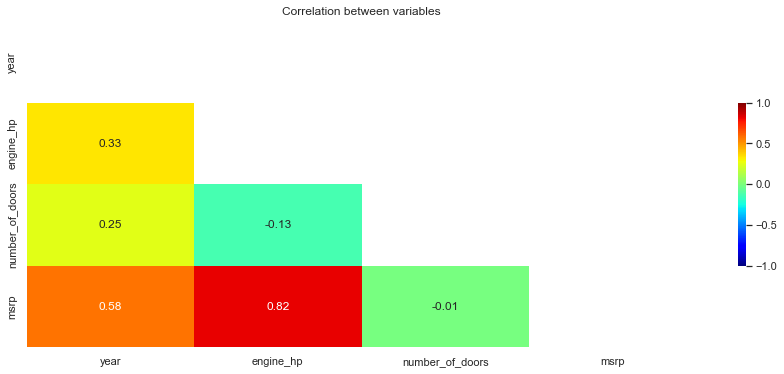

In [11]:
sb.set_theme(style="white")
car_corr  = cleaned_car_data.corr()
mask = np.triu(cleaned_car_data.corr())
f, ax = plt.subplots(figsize=(15, 6))
plt.title('Correlation between variables')

sb.heatmap(car_corr, 
            mask=mask, 
            cmap='jet', 
            annot=True,
            fmt='.2f',
            vmin=-1, 
            vmax=1,
            center=0,
            cbar_kws={"shrink": .5}
            );

In [12]:
cleaned_car_data.to_csv('cleaned_car_data.csv')
cleaned_car_data.head()

,make,year,engine_fuel_type,engine_hp,transmission_type,driven_wheels,number_of_doors,vehicle_size,vehicle_style,msrp,new_model
0,Bmw,2011,Premium Unleaded,335.0,Manual,Rear Wheel Drive,2,Compact,Coupe,46135.0,Bmw 1 Series M
1,Bmw,2011,Premium Unleaded,300.0,Manual,Rear Wheel Drive,2,Compact,Convertible,40650.0,Bmw 1 Series
2,Bmw,2011,Premium Unleaded,300.0,Manual,Rear Wheel Drive,2,Compact,Coupe,36350.0,Bmw 1 Series
3,Bmw,2011,Premium Unleaded,230.0,Manual,Rear Wheel Drive,2,Compact,Coupe,29450.0,Bmw 1 Series
4,Bmw,2011,Premium Unleaded,230.0,Manual,Rear Wheel Drive,2,Compact,Convertible,34500.0,Bmw 1 Series


## Data analysis
Relationship and distribution between features.

### Univariate analysis
The univariate analysis in the categorical column visualises the distribution of distinct row in each column from the highest to the lowest.

In [13]:
def categorical_count(data, category_col):
    if data[category_col].dtype == 'object':
        num_of_unique_row = data[category_col].nunique()
        print(f'Number of unique rows in {category_col} column is: { num_of_unique_row}.')
        
    frame_data = data[category_col].value_counts(ascending=False).to_frame().reset_index()[:20]
    frame_data.rename(columns={frame_data.columns[0]: 'features', frame_data.columns[-1] : 'count_of_features'}, inplace= True)
    
    fig =px.bar(frame_data,
                x='features', 
                y='count_of_features',
                height = 400, 
                width = 1000,
                text='count_of_features',
                title= (f'Top count in {category_col.upper()} column'),
                color_discrete_sequence = ['green']
                )
    fig.update_traces(textfont_size=12, textangle=0, textposition='outside', cliponaxis=False)
    fig.show()

categorical_count(cleaned_car_data, 'make')

Number of unique rows in make column is: 48.


In [14]:
categorical_count(cleaned_car_data, 'engine_fuel_type')

Number of unique rows in engine_fuel_type column is: 6.


In [15]:
categorical_count(cleaned_car_data, 'transmission_type')

Number of unique rows in transmission_type column is: 5.


In [16]:
categorical_count(cleaned_car_data, 'driven_wheels')

Number of unique rows in driven_wheels column is: 4.


In [17]:
categorical_count(cleaned_car_data, 'vehicle_size')

Number of unique rows in vehicle_size column is: 3.


In [18]:
categorical_count(cleaned_car_data, 'vehicle_style')

Number of unique rows in vehicle_style column is: 16.


In [19]:
categorical_count(cleaned_car_data, 'new_model')

Number of unique rows in new_model column is: 928.


In [20]:
def numeric_column(data, numeric_col):
    fig = fig = px.histogram(data, x=numeric_col,
                         height = 400, 
                         width = 1000,
                         color_discrete_sequence = ['green'],
                         title= (f'{numeric_col.upper()} distribution')
                         )
    fig.show()
numeric_column(cleaned_car_data, 'msrp')

In [21]:
numeric_column(cleaned_car_data, 'engine_hp')

In [22]:
num_of_doors = cleaned_car_data['number_of_doors'].value_counts().to_frame().reset_index()

fig = px.pie(num_of_doors, 
             values = 'number_of_doors', 
             names = 'index', 
             title = 'Number 0f doors distribution',
             hole = 0.4,
             width = 600,
             color_discrete_sequence = ['darkgreen', 'lightgreen', 'black', 'red'])
fig.update_traces(textinfo = 'percent', textfont_size = 15)
fig.show()

### Bivariate analysis

Top cars in demand and their features based on dataset entry.

In [23]:
top_make_model= cleaned_car_data.groupby(['new_model', 'engine_fuel_type', 'transmission_type', 'driven_wheels', 'vehicle_size', 'number_of_doors'])['msrp'].sum().reset_index() 
top_make_model =top_make_model.sort_values('msrp', ascending= False)[:20]

fig = px.bar(top_make_model, 
             y='msrp', 
             x='new_model', 
             text_auto='.2s',
             hover_data=['engine_fuel_type', 'transmission_type',	'driven_wheels', 'vehicle_size', 'number_of_doors'],
            title="Most expensive car and its features",
            color_discrete_sequence = ['green'])
fig.update_traces(textfont_size=12, textangle=0, textposition='outside', cliponaxis=False)

fig.show()

## Modeling
In this section, supervised machine learning model (SML) is applied on the dataset. SML algorithm learn from labeled data to predict the result of unforseen data, it is divided into regression and classification model. **Regression** is used when there is a relationship between the input and output variables such as weather forecast e.t.c while **Classification** is used when the output variable is categorical such as churn or non-churn, fraud or legit.

Based on the type of data in use and the expected outcome of the analysis, a supervised machine learning regression model is applied on the dataset. Regression models will be use to solve the regression problem i.e how a dependent variable is affected by the independent variable.

### Split into train and test set

In [24]:
# split data
independent = cleaned_car_data.drop('msrp', axis=1)
dependent = cleaned_car_data['msrp']

In [25]:
independent_train, independent_test, dependent_train, dependent_test = train_test_split(independent, dependent, random_state = 1, shuffle = True, test_size = 0.2, train_size = 0.8)

### One-hot encoder
Encode categorical features in dataset.

In [26]:
categorical_column =independent.select_dtypes('object').columns
numerical_col = independent.select_dtypes('number').columns 

one_hot = OneHotEncoder()
one_hot.fit(independent[categorical_column])

OneHotEncoder()

### Make-column-transformer
This combine both label encoding and one-hot encoding in a single column to transform categorical column.

In [27]:
column_trans =make_column_transformer((OneHotEncoder(categories=one_hot.categories_), categorical_column), remainder='passthrough')

### Pipeline and Model selection

In [44]:
models = {
    "Linear regression": LinearRegression(),
    "Linear regression (Ridge)": Ridge(),
    "Linear regression (Lasso)": Lasso(),
    "Random forest": RandomForestRegressor(),
    "Gradient boosting": GradientBoostingRegressor()
}

for item, model in models.items():
    pipe=make_pipeline(column_trans, model)  # pipeline
    pipe.fit(independent_train, dependent_train)
    dependent_pred= pipe.predict(independent_test)
    print(f'{item} r2 score: {r2_score(dependent_test, dependent_pred)}')

Linear regression r2 score: 0.9629021984159805
Linear regression (Ridge) r2 score: 0.809210109199675
Linear regression (Lasso) r2 score: 0.9552817441638563
Random forest r2 score: 0.9710315449812179
Gradient boosting r2 score: 0.9299504661879292


### Prediction
The best model that accurately predict the price is RandomForest.

In [45]:
rf = RandomForestRegressor()
pipe=make_pipeline(column_trans, rf)  # pipeline
pipe.fit(independent_train, dependent_train)
dependent_pred= pipe.predict(independent_test)

In [46]:
pipe.predict(pd.DataFrame(columns= independent_test.columns, data=np.array(['Bmw', 2011, 'Premium Unleaded', 300, 'Manual','Rear Wheel Drive', 2,'Compact', 'Convertible', 'Bmw 1 Series M']).reshape(1,10)))

array([45468.16666667])

### Evaluation

To check if the error-term are normally distributed.

Text(0, 0.5, 'Predicted Values')

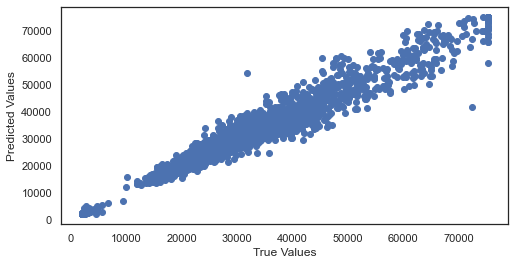

In [58]:
fig=plt.figure(figsize=(8,4))
plt.scatter(dependent_test, dependent_pred)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")

Text(0.5, 0, 'Errors')

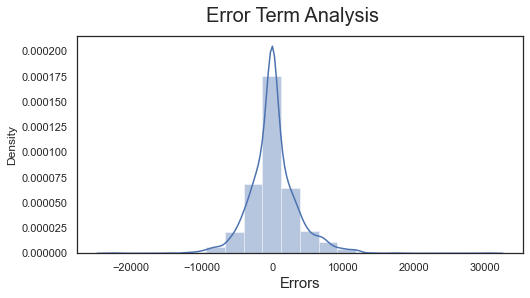

In [60]:
fig=plt.figure(figsize=(8,4))
sb.distplot((dependent_test - dependent_pred), bins=20)
fig.suptitle('Error Term Analysis', fontsize=20)
plt.xlabel('Errors', fontsize=15)

### Feature importance
What feature most predict the model

In [65]:
# # feature importance to model
# feat_imp = pd.DataFrame(independent_train.columns, columns=["features"]) 
# feat_imp["importance"] = pipe.feature_importances_
# feat_imp.sort_values('Importance', ascending = False, inplace= True)
# feat_imp = feat_imp.head()


In [37]:
import pickle

In [38]:
with open('random_forest_model.pickle', 'wb') as file:    # store data in binary format
    pickle.dump(pipe, file)

Deploy model using flask: (define a set of constraint for the web app to send and receive data) and heroku(allows application running on cloud possible) applications